In [9]:
from dotenv import load_dotenv

from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from openai import OpenAI
import subprocess

# import .env variables
load_dotenv()

class State(TypedDict):
  # the video input file
  video_file: str
  # the audio input file
  audio_file: str
  # the transcription of the video
  transcription: str

In [ ]:
def extract_audio(state: State):
  # extract the audio of mp4 file using ffmpeg

  # converts mp4 video into mp3 audio file
  output_file = state["video_file"].replace("mp4", "mp3")

  # ffmpeg command to extract audio from video
  # e.g. $ ffmpeg -i input.mp4 output.avi
  command = [
    "ffmpeg",
    "-i",
    state["video_file"],
    # filter to the audio
    "-filter:a",
    # speed up video (doesn't change the quality of transcription but cheaper since shorter video)
    "atempo=2.0",
    # answers yes to all prompts (do you want to overwrite the file if it already exists)
    "-y",
    output_file
  ]

  # run the command in the terminal
  subprocess.run(command)

  # update the 'audio_file' state
  return {
    "audio_file": output_file
  }

def transcribe_audio(state: State):
  # transcribe the audio file using whisper
  client = OpenAI()
  
  # open the audio file
  # state["audio_file"] is the path to the audio file
  # file requires a file-like object
  # 'rb' - open the file for reading in binary mode
  with open(state["audio_file"], "rb") as audio:
    # create the transcription
    transcription = client.audio.transcriptions.create(
      # required - 'file', 'model'
      # optional - 'response_format', 'language', etc...
      file=audio,
      model="whisper-1",
      response_format="text",
      # The language of the input audio. 
      # Supplying the input language in ISO-639-1 (e.g. en) format will improve accuracy and latency.
      language="en",
      # helps the model to understand the context of the video
      prompt="Netherlands, Rotterdam, Amsterdam, The Hague"
    )

  # update the 'transcription' state
  return {
    "transcription": transcription
  }

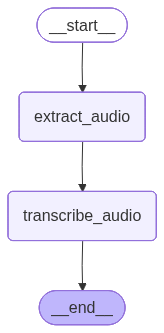

In [11]:

# create the state graph
graph_builder = StateGraph(State)

# create the nodes using the predefined functions
graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)

# create the edges between the nodes
graph_builder.add_edge(START, "extract_audio")
graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_edge("transcribe_audio", END)

# compile the graph
graph = graph_builder.compile()

graph

In [12]:
graph.invoke({"video_file": "video.mp4"})

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.3.19.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --e

{'video_file': 'video.mp4',
 'audio_file': 'video.mp3',
 'transcription': "This episode is supported by Audible. Amazon Prime members can get an incredible 66% off their first 3 months at audible.com slash sui b h n e. Only available for a limited time, so sign up fast. Feudalism helped sway in the land, and as the trade increased, the cities of Amsterdam, Brugge, and Antwerpen prospered, and soon these trading posts became more and more integrated into the Hanseatic League, a sort of trade agreement in the North Sea after the Viking raids had ceased. Through both conquest and inheritance, the Dutch counties came under the control of the House of Burgundy, who then passed it on to the Austrian House of Habsburg. They pulled the Netherlands out of the Hanseatic League and then took over control of trade themselves. This is known as the Era of the Seventeen Provinces, but by this point the merchants had begun to embrace Calvinist Protestantism. This led to the Dutch Revolt, also known as